#Предобработка данных

Предобработка баззы данных:

1. База для распознавания пола

  Эта база не подвергалась изменениям, так как фотографии уже были нужного формата.

2. База для распознавания возраста

  Было проведено 2 теста. 1 - база без изменений, 2 - изображения были кропнуты так, что было видно только лицо.

  По итогу был выбран вариант использования базы без изменений, так как точность была выше.

3. При создании выборок обе базы прошли через ImageDataGenerator

4. Предобработка входных данных для распознавания в готовой версии проекта

  Полученное фото кропоется так, что видно только лицо. Это было сделано для того, чтобы на изображении не было лишних элементов и НС лучше предсказывала результат. Так же изменялся размер изображение до 60*80. Код предобработки входного изображения представлен ниже.

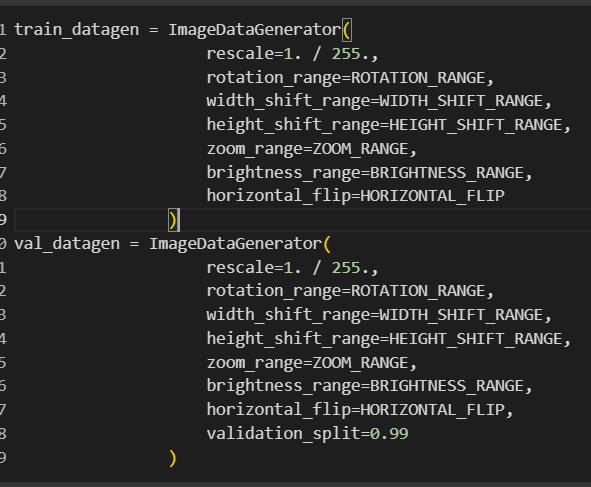

In [ ]:
    # Получение фотографии, отправленной пользователем в телеграмме

    file_id = message.photo[-1].file_id  # Получаем ID файла фотографии
    file_info = bot.get_file(file_id)  # Получаем информацию о файле фотографии
    file = bot.download_file(file_info.file_path)
    image = Image.open(io.BytesIO(file))

    # Изпользование предобученной нейронной сети MTCNN для поиска и кропа лица на фото
    detector = MTCNN()

    # Детекция лиц на фотографии
    faces = detector.detect_faces(np.array(image))
    if len(faces) == 0: bot.send_message(message.chat.id, "Лиц на фото не найдено")
    # Обработка каждого лица
    for face in faces:
        x, y, width, height = face['box'] # Полчение координат и размера найденного лица
        cropped_face = np.array(image)[y:y + height, x:x + width]

        # Преобразование изображения для отправки в Telegram
        cropped_face = Image.fromarray(cropped_face)
        cropped_face = cropped_face.resize((60, 80)) # Изменение размера изображения
        cropped_face = np.array(cropped_face) / 255.0 # Перевод изображения в массив и нормализация
        cropped_face = np.expand_dims(cropped_face, axis=0)

        # Предикт

# Эксперименты

К сожалению ноутбуков со старыми версиями НС не сохранилось, так как работу над проектом начал довольно давно, но сохранились скриншоты обучений НС.

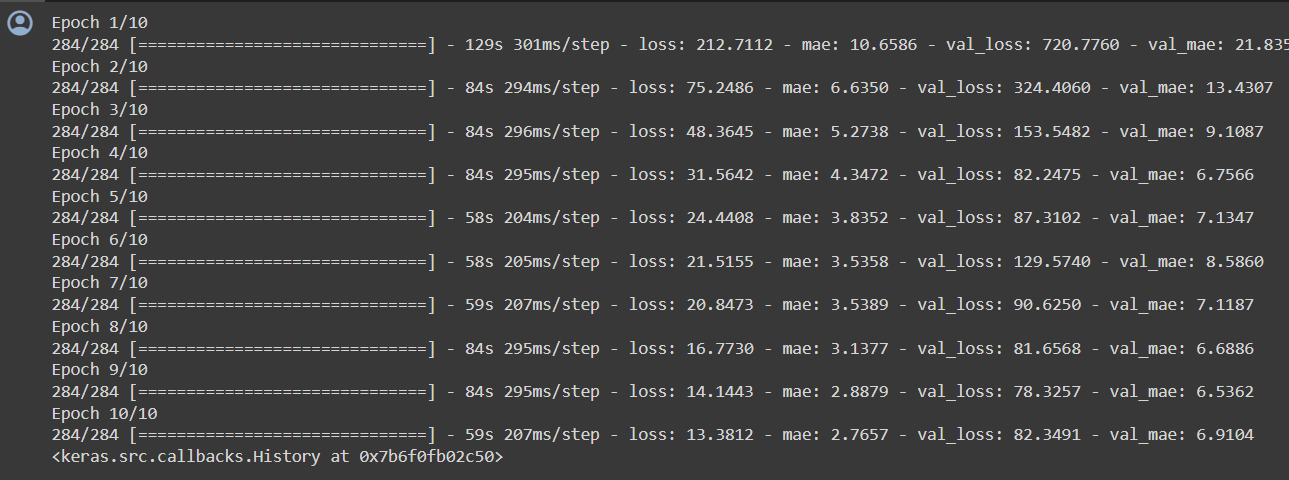

На фотографии выше представленно обучения НС для определения возраста. На последней эпохе метрика MAE была 6.9

На финальной версии модели метрика получилась 5.5

В основном пытался изменять гиперпараметры НС, так же проводил эксперемент с кропнутой базой(писал в пункте про предобработку). Добиться более лучшего результатат не получилось, возможно из-за маленькой базы, но так же была проблема с долгим обучением и колаб не давал возможность использовать ускорители из-за лимитов.

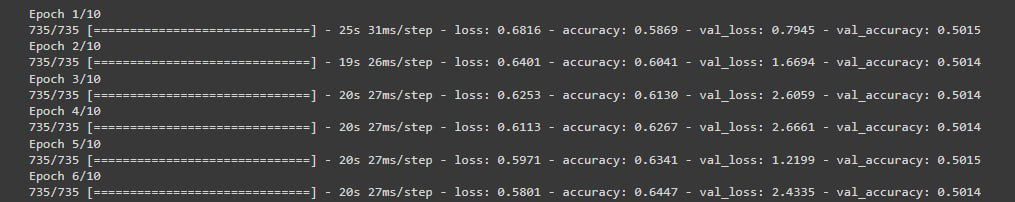

На фотографии выше представлено часть обучения НС для определения пола. По метрике val_accuracy видно, что модель не обучалась.

Для этой НС были тесты с разными архитектурами, самый лучший результат показала ResNet, поэтому она была выбрана и для другой сети изначально.

Также проводил эксперементы с гиперпараметрами. На финальной версии метрика val_accuracy получилась 0.96. Это был наилучший результат, на которм я решил остановиться.

# Выводы о проделанной работе

Самой сложной частью работы было добиться более высокой точности НС. Основными проблемами были: маленькая база (в случае НС для возраста) и ограничения колаба из-за который ноутбук переодически вылетал.

В ходе работы над проектом был создан телеграмм бот, в который интегрированы 2 НС для определения пола и возраста. Пользователь отправляет фотографию в бот, а он в ответ выводит предсказания. Предсказания пола работает в 90% случаев, с возрастом сложнее, но почти всегда выводит цифру в диапазоне +-5 лет от реального возраста.

#Рабочая версия проекта

Ссылка на бота - https://t.me/AI_Project_Gender_bot

библиотеки

In [ ]:
!pip install pyTelegramBotAPI
!pip install mtcnn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.6/240.6 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 10.4 MB/s eta 0:00:00


In [ ]:
import telebot
from telebot import types
from PIL import Image
import numpy as np
from tensorflow import keras
import io
import cv2
from mtcnn.mtcnn import MTCNN
import requests
import h5py
import tensorflow as tf
from io import BytesIO

загрузка моделей

In [ ]:
def load_model_from_h5_url(url):
    # Загрузка файла H5 из URL
    response = requests.get(url)
    if response.status_code != 200:
        raise Exception("Failed to download the H5 file")

    # Создание объекта BytesIO для чтения данных
    h5_data = BytesIO(response.content)

    # Загрузка модели из файла H5
    with h5py.File(h5_data, 'r') as h5_file:
        model = tf.keras.models.load_model(h5_file)

    return model

model_url_age = 'https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/fSXNlTrrJgvVWw'
model_url_gender = 'https://drive.usercontent.google.com/u/0/uc?id=10GnjtA3Siy7NQShTojvJBWBE2zoo6B9z&export=download'
model_age = load_model_from_h5_url(model_url_age)
model_gender = load_model_from_h5_url(model_url_gender)

апи бота и маркап

In [ ]:
bot = telebot.TeleBot('7103743750:AAF5gfkQ6XWJ2hUsmD0afNRFRbGU6p9HpDA')
markup = types.ReplyKeyboardMarkup(resize_keyboard=True, one_time_keyboard=False)
btn1 = types.KeyboardButton('info')
markup.add(btn1)

обработка команд старт и инфо

In [ ]:
@bot.message_handler(commands=['start'])
def start(message):
    bot.send_message(message.from_user.id, "👋 Привет!", reply_markup=markup)


@bot.message_handler(func=lambda message: message.text == 'info')
def request_photo(message):
    bot_info_text = "Телеграмм бот для определения возраста и пола человека по фото. Просто отправьте фото"
    bot.send_message(message.chat.id, bot_info_text, parse_mode='Markdown')

ожидание фото и предикт

In [ ]:
GENDER = {0: 'Woman', 1: 'Man'}

@bot.message_handler(content_types=['photo'])
def handle_image(message):
    file_id = message.photo[-1].file_id  # Получаем ID файла фотографии
    file_info = bot.get_file(file_id)  # Получаем информацию о файле фотографии
    file = bot.download_file(file_info.file_path)
    image = Image.open(io.BytesIO(file))

    detector = MTCNN()

    # Детекция лиц на фотографии
    faces = detector.detect_faces(np.array(image))
    if len(faces) == 0: bot.send_message(message.chat.id, "Лиц на фото не найдено")
    # Обработка каждого лица
    for face in faces:
        x, y, width, height = face['box']
        cropped_face = np.array(image)[y:y + height, x:x + width]

        # Преобразование изображения для отправки в Telegram
        cropped_face = Image.fromarray(cropped_face)
        cropped_face = cropped_face.resize((60, 80))
        cropped_face = np.array(cropped_face) / 255.0
        cropped_face = np.expand_dims(cropped_face, axis=0)

        # Отправка изображения в Telegram
        photo_byte_array = io.BytesIO()
        Image.fromarray((cropped_face[0] * 255).astype(np.uint8)).save(photo_byte_array, format='PNG')
        photo_byte_array.seek(0)
        bot.send_photo(message.chat.id, photo_byte_array)

        # Предсказание пола
        predictions = model_gender.predict(cropped_face)
        class_id = np.argmax(predictions)
        bot.send_message(message.chat.id, "Пол: " + str(GENDER[class_id]))

        img_age = np.array(image)[y:y + height, x:x + width]
        img_age = Image.fromarray(img_age)
        img_age = img_age.resize((224, 224))
        img_age = np.array(img_age) / 255.0
        img_age = np.expand_dims(img_age, axis=0)
        predictions = model_age.predict(img_age)
        bot.send_message(message.chat.id, "Лет примерно: " + str(round(predictions[0][0])))

@bot.message_handler(content_types=['text'])
def get_text_messages(message):
    bot.send_message(message.from_user.id, 'Пришлите фото', reply_markup=markup)


bot.polling(none_stop=True, interval=0)  # обязательная для работы бота часть

1/1 [==============================] - 1s 555ms/step


1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 0s 24ms/step


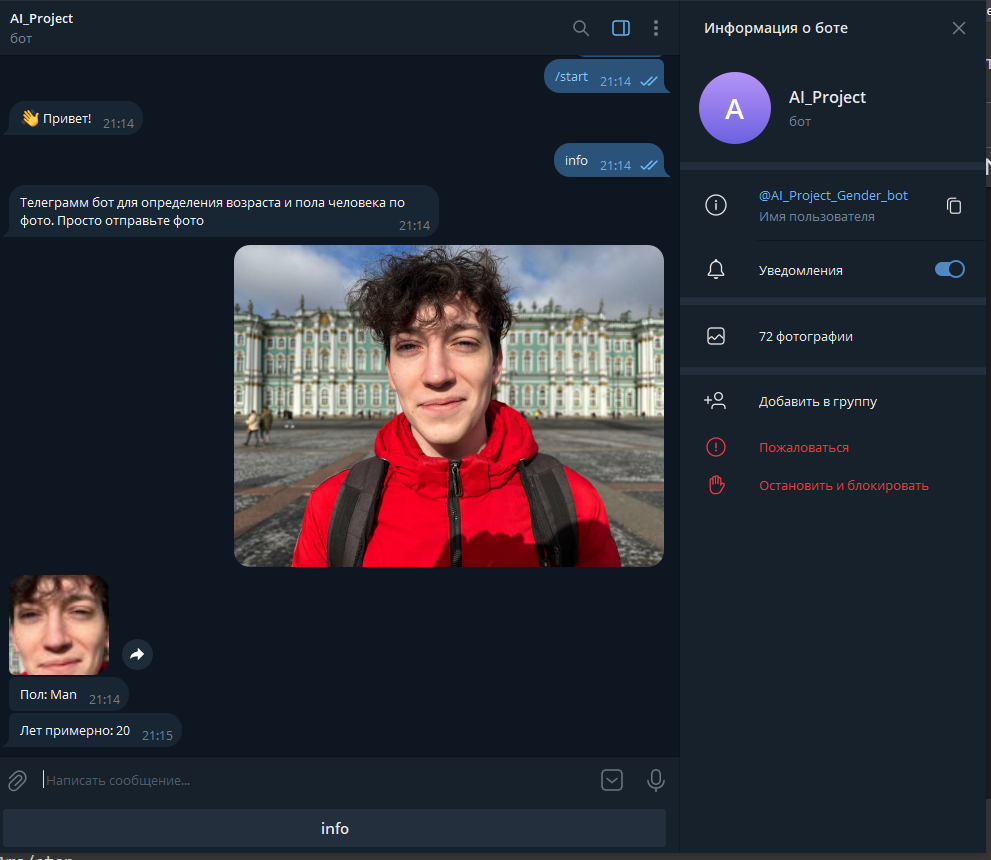